# Desafio Kaggle - Titanic
## Equipe:
* Ricardo Galiardi 
* Wanderson Henrique dos Santos
* Neri Silvestre Filho

In [ ]:
# Caso alguma biblioteca não esteja instalada (descomente a linha)

# Importando xgboost
#!pip install xgboost

# Caso seja necessário atualizar o pacote scikit
#!pip install --force-reinstall scikit-learn==0.20rc1

# Referências

__[score 0.9751](https://www.kaggle.com/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy/notebook)__

__[score 0.8134](https://ahmedbesbes.com/how-to-score-08134-in-titanic-kaggle-challenge.html)__

__[Boa referência para a separação dos dados e predição](http://aplunket.com/titanic-kaggle-xgboost/)__

In [1]:
# Importando os módulos das bibliotecas de Data Science

import sys
import IPython 
from IPython import display

import numpy as np
import pandas as pd      

import sklearn as sk
import scipy as sp

import matplotlib as plt   
import seaborn as sns; sns.set(style="ticks", color_codes=True)

import Functions as fn
import fn_MLComparison as fnc
import fn_MLAlgorithm as fna

# Faz com que os relatórios (plots) sejam apresentados em uma célula e não em uma nova janela
%matplotlib inline       

-------------------------


In [2]:
# Checando as versões para acompanhamento de atualizações

print("Python version: {}". format(sys.version))
print("NumPy version: {}". format(np.__version__))
print("pandas version: {}". format(pd.__version__))
print("matplotlib version: {}". format(plt.__version__))
print("SciPy version: {}". format(sp.__version__)) 
print("scikit-learn version: {}". format(sk.__version__))
print("IPython version: {}". format(IPython.__version__)) 

Python version: 3.6.5 |Anaconda, Inc.| (default, Mar 29 2018, 13:32:41) [MSC v.1900 64 bit (AMD64)]
NumPy version: 1.14.3
pandas version: 0.23.0
matplotlib version: 2.2.2
SciPy version: 1.1.0
scikit-learn version: 0.19.1
IPython version: 6.4.0


In [21]:
# Prepara os dados - importando os datasets

dsTrain = pd.read_csv('./Data/train.csv', 
                      names=['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], 
                      sep=',', header=0)

dsTest  = pd.read_csv('./Data/test.csv',  
                      names=['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], 
                      sep=',', header=0)

# Verifica a importação dos dados de treino
print(dsTrain.count())
print('\n')
# Verifica a importação dos dados de teste
print(dsTest.count())

PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            714
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       889
dtype: int64


PassengerId    418
Pclass         418
Name           418
Sex            418
Age            332
SibSp          418
Parch          418
Ticket         418
Fare           417
Cabin           91
Embarked       418
dtype: int64


In [22]:
# Cria um dataset com os dois datasets: Treino e de Testes para podermos tratar as variáveis de uma só vez

# Cria novos datasets com a coluna do tipo: treino: 0 e teste: 1
mTrain = dsTrain.copy()
mTest = dsTest.copy()

# Incluíndo as colunas de checagem
mTrain['Train'] = 1
mTrain['FamilySize'] = 1
mTrain['IsAlone'] = 1

mTest['Train'] = 0
mTest['FamilySize'] = 1
mTest['IsAlone'] = 1

In [23]:
# Excluíndo as primeiras colunas que não serão utilizadas pelo modelo e nem usadas pela normalização

drop_column = ['Ticket']
mTrain.drop(drop_column, axis=1, inplace = True)
mTest.drop(drop_column, axis=1, inplace = True)

In [24]:
# Cria uma junção dos dados de treino e teste dados

dsCombined = mTrain.append(mTest, ignore_index=True, sort=False)
dsCombined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
PassengerId    1309 non-null int64
Survived       891 non-null float64
Pclass         1309 non-null int64
Name           1309 non-null object
Sex            1309 non-null object
Age            1046 non-null float64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Fare           1308 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Train          1309 non-null int64
FamilySize     1309 non-null int64
IsAlone        1309 non-null int64
dtypes: float64(3), int64(7), object(4)
memory usage: 143.2+ KB


In [25]:
# Limpeza dos dados e tratamento de dados missing
## Pela avaliação teremos que tratar as colunas: Age e Embarked, não iremos tratar Cabin, por não ser relevante
## E criar novos campos de tratamento

#Pclass
dsCombined['Pclass'] = dsCombined['Pclass'].astype(int)

#SibSp and Parch
dsCombined['FamilySize'] = dsCombined ['SibSp'] + dsCombined['Parch'] + 1

#Size
dsCombined.loc[dsCombined['FamilySize'] > 1, 'IsAlone'] = 0

#Embarked
dsCombined['Embarked'] = dsCombined['Embarked'].fillna('Unknown')

#Fare
dsCombined['Fare'].fillna(dsCombined['Fare'].notna().median())

#Age
dsCombined['Age'].fillna(dsCombined['Age'].notna().median())

#Title
fn.setTitle(dsCombined, 'Name', 'Title')

#Cabin
dsCombined['Cabin'] = dsCombined['Cabin'].fillna('Unknown')
dsCombined['Cabin'] = dsCombined['Cabin'].str[0]

In [26]:
dsCombined.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Train,FamilySize,IsAlone,Title,Title_Code
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,U,S,1,2,0,Mr,12.0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,C,1,2,0,Mrs,13.0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,U,S,1,1,1,Miss,14.0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,C,S,1,2,0,Mrs,13.0
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,U,S,1,1,1,Mr,12.0


In [27]:
# Separação dos dados para normalização

## Importar a biblioteca de encoding
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

label = LabelEncoder()

dsCombined['Sex_Code'] = label.fit_transform(dsCombined['Sex'])
dsCombined['Age_Code'] = label.fit_transform(dsCombined['Age'])
dsCombined['Fare_Code'] = label.fit_transform(dsCombined['Fare'])
dsCombined['Cabin_Code'] = label.fit_transform(dsCombined['Cabin'])
dsCombined['Embarked_Code'] = label.fit_transform(dsCombined['Embarked'])
dsCombined['Title_Code'] = label.fit_transform(dsCombined['Title'])

In [28]:
# Analisando os dados

print(dsCombined.info())
dsCombined.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 21 columns):
PassengerId      1309 non-null int64
Survived         891 non-null float64
Pclass           1309 non-null int32
Name             1309 non-null object
Sex              1309 non-null object
Age              1046 non-null float64
SibSp            1309 non-null int64
Parch            1309 non-null int64
Fare             1308 non-null float64
Cabin            1309 non-null object
Embarked         1309 non-null object
Train            1309 non-null int64
FamilySize       1309 non-null int64
IsAlone          1309 non-null int64
Title            1309 non-null object
Title_Code       1309 non-null int64
Sex_Code         1309 non-null int64
Age_Code         1309 non-null int64
Fare_Code        1309 non-null int64
Cabin_Code       1309 non-null int64
Embarked_Code    1309 non-null int64
dtypes: float64(3), int32(1), int64(12), object(5)
memory usage: 209.7+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,...,Train,FamilySize,IsAlone,Title,Title_Code,Sex_Code,Age_Code,Fare_Code,Cabin_Code,Embarked_Code
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,U,...,1,2,0,Mr,12,1,32,20,8,2
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,...,1,2,0,Mrs,13,0,57,237,2,0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,U,...,1,1,1,Miss,9,0,39,50,8,2
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,C,...,1,2,0,Mrs,13,0,53,217,2,2
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,U,...,1,1,1,Mr,12,1,53,52,8,2


In [29]:
# Terminando o último tratamento do dataset para disponibilização para análise e predição.

# Fazendo uma cópia dos dados para análise
dsAnalize = dsCombined.copy()

# Excluíndo as colunas que não serão utilizadas pelo modelo após a normalização
drop_column = ['Name','Sex', 'Age', 'Fare', 'Cabin', 'Embarked', 'Title']
dsAnalize.drop(drop_column, axis=1, inplace = True)

In [30]:
# Analisando os dados

print(dsAnalize.info())
dsAnalize.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
PassengerId      1309 non-null int64
Survived         891 non-null float64
Pclass           1309 non-null int32
SibSp            1309 non-null int64
Parch            1309 non-null int64
Train            1309 non-null int64
FamilySize       1309 non-null int64
IsAlone          1309 non-null int64
Title_Code       1309 non-null int64
Sex_Code         1309 non-null int64
Age_Code         1309 non-null int64
Fare_Code        1309 non-null int64
Cabin_Code       1309 non-null int64
Embarked_Code    1309 non-null int64
dtypes: float64(1), int32(1), int64(12)
memory usage: 138.1 KB
None


,PassengerId,Survived,Pclass,SibSp,Parch,Train,FamilySize,IsAlone,Title_Code,Sex_Code,Age_Code,Fare_Code,Cabin_Code,Embarked_Code
0,1,0.0,3,1,0,1,2,0,12,1,32,20,8,2
1,2,1.0,1,1,0,1,2,0,13,0,57,237,2,0
2,3,1.0,3,0,0,1,1,1,9,0,39,50,8,2
3,4,1.0,1,1,0,1,2,0,13,0,53,217,2,2
4,5,0.0,3,0,0,1,1,1,12,1,53,52,8,2


,Survived,Pclass,SibSp,Parch,FamilySize,IsAlone,Title_Code,Sex_Code,Age_Code,Fare_Code,Cabin_Code,Embarked_Code
Survived,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Pclass,0.333848,0.734749,0.861952,0.792296,0.861952,0.284537,0.227419,0.284537,0.150882,0.417471,0.734749,0.226411
SibSp,0.081629,0.182154,0.373587,0.373587,0.792296,0.165265,0.092331,0.227419,0.096512,0.347003,0.226411,0.182154
Parch,0.016639,0.147393,0.347003,0.346210,0.417471,0.150882,0.059259,0.125487,0.092331,0.346210,0.165265,0.095215
FamilySize,-0.035322,0.124617,0.064519,0.081629,0.066396,0.147393,0.057591,0.124617,0.073966,0.333848,0.125487,0.066396
IsAlone,-0.110275,0.096512,0.060832,0.043835,0.050027,0.063024,0.024150,0.095215,0.070468,-0.082335,0.073966,0.064519
Title_Code,-0.163517,0.060832,0.007952,0.018322,0.016639,0.059259,-0.007861,0.070468,0.006739,-0.116021,0.024150,0.063024
Sex_Code,-0.190488,0.050027,0.006739,-0.034438,-0.013592,-0.203367,-0.082335,-0.109609,-0.047268,-0.154620,0.007952,0.057591
Age_Code,-0.203367,0.018322,-0.035322,-0.094593,-0.047268,-0.516328,-0.101395,-0.188583,-0.094593,-0.247474,-0.013592,0.043835
Fare_Code,-0.301116,-0.007861,-0.109609,-0.101395,-0.179297,-0.549022,-0.179297,-0.213125,-0.109398,-0.516328,-0.034438,-0.109398


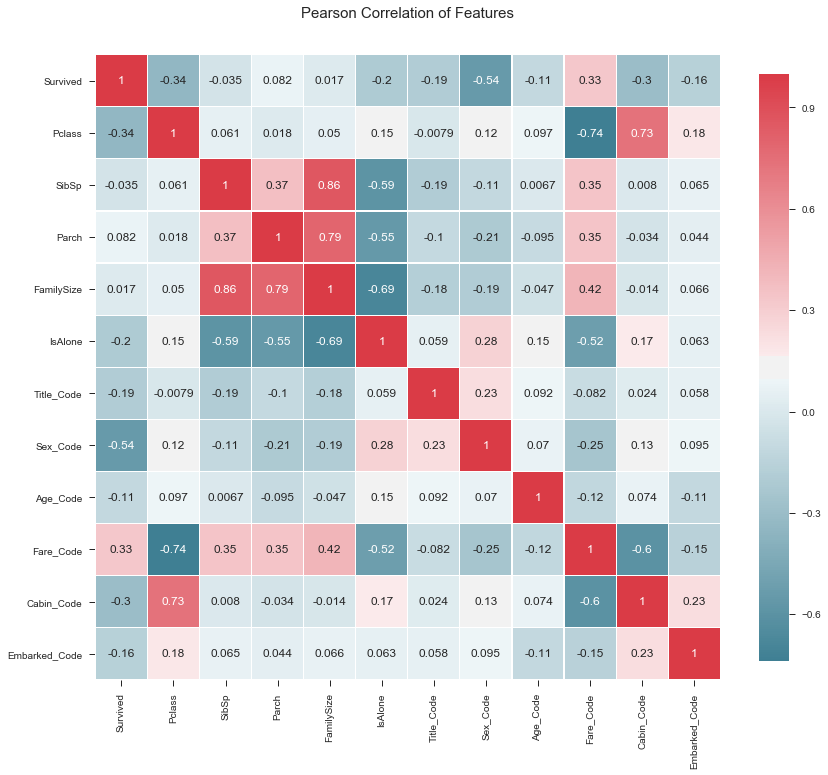

In [32]:
# Análise de Correlação de Pearson das variáveis

columns = ['Survived', 'Pclass', 'SibSp', 'Parch', 'FamilySize', 'IsAlone', 'Title_Code', 'Sex_Code', 'Age_Code', 'Fare_Code', 'Cabin_Code', 'Embarked_Code']
fn.correlation_heatmap(dsAnalize[columns])
dsAnalize[columns].corr().apply(lambda x: x.sort_values(ascending=False).values)

In [33]:
# Definição das classes de variáveis aplicaveis aos modelos

# X_train - define os dados independentes de treino
X_train = dsAnalize[dsAnalize['Train'] == 1].drop(['Survived', 'PassengerId', 'Train'], axis=1)

# y_train - define a variável preditora
y_train = dsAnalize[dsAnalize['Train'] == 1]['Survived']

# X_test - define os dados independentes de teste
X_test = dsAnalize[dsAnalize['Train'] == 0].drop(['Survived', 'PassengerId', 'Train'], axis=1)

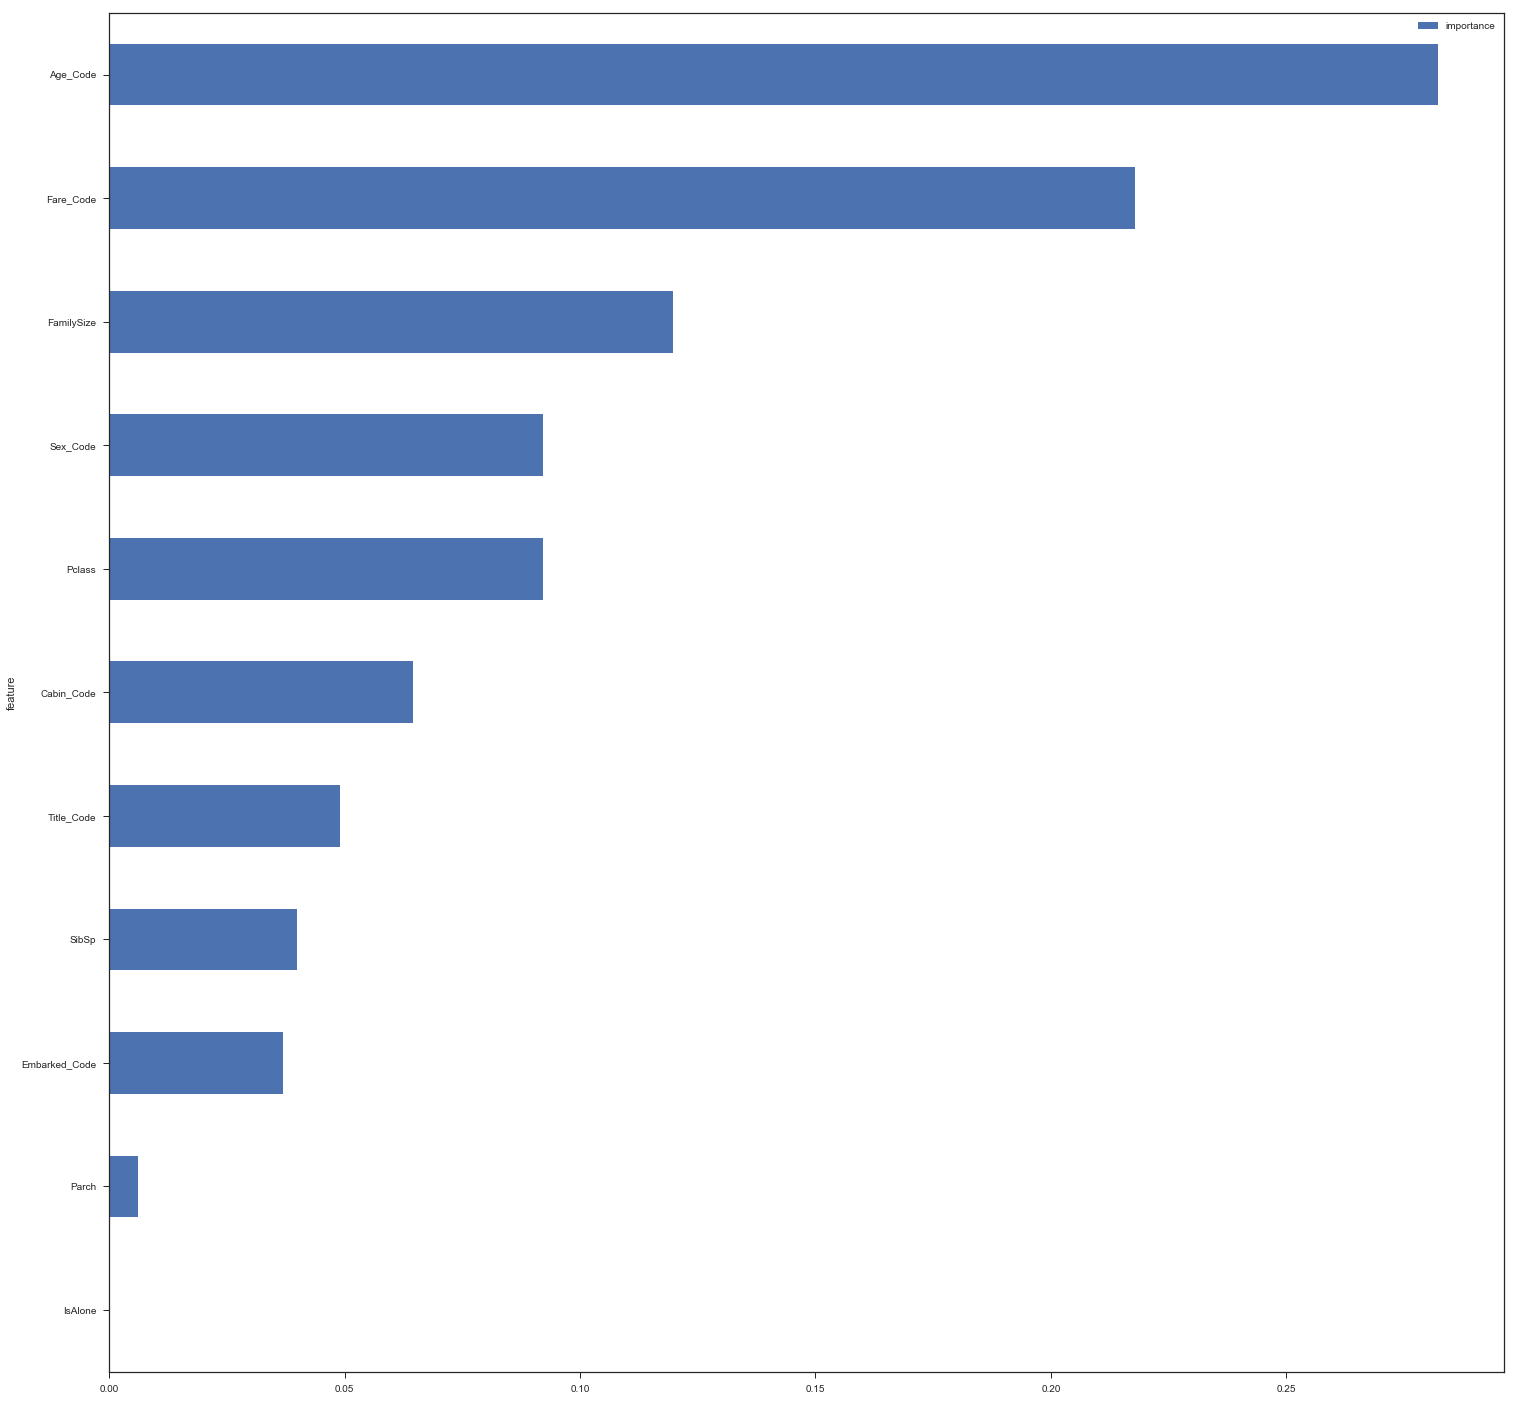

In [34]:
# Verificação das variáveis independentes e sua classificação

from sklearn.model_selection import KFold, StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

clf = XGBClassifier(n_estimators=50, max_features='sqrt')
predictions = clf.fit(X_train, y_train)

features = pd.DataFrame()
features['feature'] = X_train.columns
features['importance'] = predictions.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

features.plot(kind='barh', figsize=(25, 25))

## Classificação por Comparação

Series([], Name: (XGBClassifier, 0.9844444444444445), dtype: float64)


,
Classifier,Accuracy
XGBClassifier,0.984444
GradientBoostingClassifier,0.975556
BaggingClassifier,0.971111
ExtraTreesClassifier,0.970000
RandomForestClassifier,0.965556
DecisionTreeClassifier,0.942222
AdaBoostClassifier,0.940000
LogisticRegressionCV,0.935556
ExtraTreeClassifier,0.932222


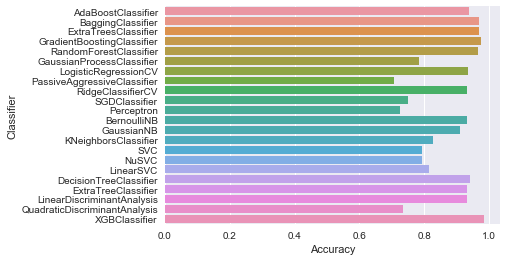

In [35]:
# Classifier(splits, target, features)

#classifiers = fnc.Classifier(12, y_train, X_train)
classifiers = fnc.Classifier(12, y_train, X_train)
print(classifiers.iloc[0])
classifiers

In [37]:
classifier = fnc.Prediction(XGBClassifier(), y_train, X_train, X_test)

## output(output, test, name)
result = fn.output(classifier, mTest, 'mlc')
result

'ok - arquivo gerado: ./Predictions/mlc.csv'

In [55]:
# Cria a matriz de Confusao: Confusion Matrix

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

print('Confusion Matrix - XGBClassifier')
predictions = cross_val_predict(XGBClassifier(), X_train, y_train, cv=10)
pd.DataFrame(confusion_matrix(y_train, predictions), columns=['Survived', 'Died'], index=['Survived', 'Die'])

Confusion Matrix - XGBClassifier


,Survived,Died
Survived,494,55
Die,103,239


## Classificação por Algoritimo (MLA)

In [57]:
# Classifier(splits, predict, target, features)
classifiers = fna.Classifier(10, 'Survived', y_train, X_train)
print(classifiers.iloc[0])
classifiers

ValueError: Could not interpret input 'Accuracy'

In [ ]:
classifier = fnc.Prediction(XGBClassifier(), y_train, X_train, X_test)

## output(output, test, name)
result = fn.output(classifier, mTest, 'mla')
result

In [49]:
# Cria a matriz de Confusao: Confusion Matrix

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

print('Confusion Matrix')
predictions = cross_val_predict(XGBClassifier(), X_train, y_train, cv=10)
pd.DataFrame(confusion_matrix(y_train, predictions), columns=['Survived', 'Died'], index=['Survived', 'Die'])

Confusion Matrix


,Survived,Died
Survived,494,55
Die,103,239
